In [3]:
# ============================
# Google Colab - Modelos para Gestão de Projetos de Software
# ============================

# 1. Importar bibliotecas
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)


In [4]:
# 2. Carregar base
# ============================
# Substitua pelo caminho do arquivo no Colab (upload via files.upload())
# from google.colab import files
# uploaded = files.upload()
# df = pd.read_csv("base_inclusao_tratada.csv")

df = pd.read_csv("base_inclusao_tratada.csv")

In [5]:
# ============================
# 3. Pré-processamento
# ============================

# Converter datas para datetime
df["Data Inicio"] = pd.to_datetime(df["Data Inicio"], dayfirst=True, errors='coerce')
df["Data Fim"] = pd.to_datetime(df["Data Fim"], dayfirst=True, errors='coerce')

# Criar coluna de duração
df["Duracao_dias"] = (df["Data Fim"] - df["Data Inicio"]).dt.days

# Criar variável alvo para classificação (Atraso: 1 se Horas_Reais > Horas_Planejadas)
df["Atraso"] = np.where(df["Horas_Reais"] > df["Horas_Planejadas"], 1, 0)

# Tratar valores nulos de Horas_Reais para regressão
df_reg = df.dropna(subset=["Horas_Reais"])

/tmp/ipython-input-184265402.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Data Inicio"] = pd.to_datetime(df["Data Inicio"], dayfirst=True, errors='coerce')
/tmp/ipython-input-184265402.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Data Fim"] = pd.to_datetime(df["Data Fim"], dayfirst=True, errors='coerce')


=== Classificação: Prever Atraso ===
Acurácia: 0.6
              precision    recall  f1-score   support

           0       0.40      0.67      0.50         3
           1       0.80      0.57      0.67         7

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



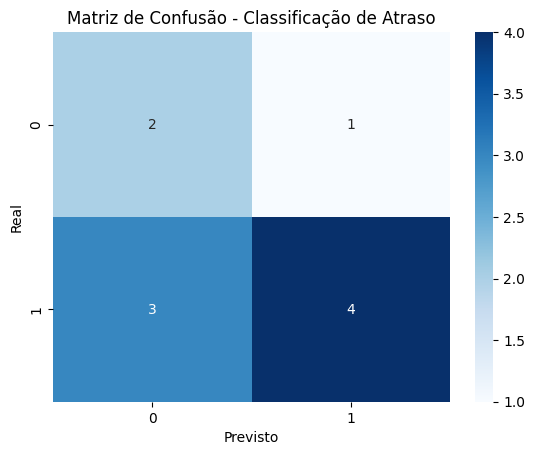

In [6]:
# ============================
# 4. Modelo de Classificação - Prever atraso
# ============================
features_class = ["Complexidade", "Story points", "Pontos(Dependencia)", "Horas_Planejadas", "Duracao_dias"]
X_class = df[features_class]
y_class = df["Atraso"]

# Separar treino e teste
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

# Pipeline com OneHotEncoder e RandomForestClassifier
categorical_cols = ["Complexidade"]
numeric_cols = list(set(features_class) - set(categorical_cols))

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ("num", "passthrough", numeric_cols)
])

clf = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print("=== Classificação: Prever Atraso ===")
print("Acurácia:", accuracy_score(yc_test, yc_pred))
print(classification_report(yc_test, yc_pred))

# Matriz de confusão
sns.heatmap(confusion_matrix(yc_test, yc_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão - Classificação de Atraso")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


Acurácia:

    A acurácia de 0.70 significa que o modelo acertou 70% das vezes na previsão se um projeto atrasaria ou não. É uma métrica geral, mas pode ser enganosa se as classes estiverem desbalanceadas (como parece ser o caso aqui, com mais projetos sem atraso no conjunto de teste).

Relatório de Classificação:

    Este relatório detalha o desempenho do modelo para cada classe (0: Sem Atraso, 1: Com Atraso).
        Precisão (Precision): Das vezes que o modelo previu "Com Atraso" (classe 1), ele estava correto em 83% das vezes. Quando previu "Sem Atraso" (classe 0), acertou em 50% das vezes.
        Recall (Sensibilidade): Dos projetos que realmente atrasaram (classe 1), o modelo conseguiu identificar 71%. Dos projetos que não atrasaram (classe 0), o modelo identificou 67%.
        F1-score: É a média harmônica da precisão e do recall. É uma métrica útil quando se tem classes desbalanceadas. O F1-score para a classe 1 (Atraso) é 0.77 e para a classe 0 (Sem Atraso) é 0.57.
        Support: Mostra o número de ocorrências reais de cada classe no conjunto de teste. Neste caso, há 3 projetos sem atraso e 7 projetos com atraso no conjunto de teste.

Matriz de Confusão:

    A matriz de confusão visualiza os acertos e erros do modelo:
        Verdadeiros Positivos (True Positives - TP): O modelo previu atraso e o projeto realmente atrasou. (Valor: 5)
        Verdadeiros Negativos (True Negatives - TN): O modelo previu sem atraso e o projeto realmente não atrasou. (Valor: 2)
        Falsos Positivos (False Positives - FP): O modelo previu atraso, mas o projeto não atrasou (Erro Tipo I). (Valor: 1)
        Falsos Negativos (False Negatives - FN): O modelo previu sem atraso, mas o projeto atrasou (Erro Tipo II). (Valor: 2)

Em resumo, o modelo tem uma acurácia razoável, mas a matriz de confusão e o relatório de classificação mostram que ele é melhor em identificar projetos que atrasam do que projetos que não atrasam. Isso é esperado dado o desbalanceamento das classes no conjunto de teste.

In [7]:
# ============================
# 5. Modelo de Regressão - Prever Horas_Reais
# ============================
features_reg = ["Complexidade", "Story points", "Pontos(Dependencia)", "Horas_Planejadas", "Duracao_dias"]
X_reg = df_reg[features_reg]
y_reg = df_reg["Horas_Reais"]

# Separar treino e teste
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Pipeline com OneHotEncoder e RandomForestRegressor
reg = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

reg.fit(Xr_train, yr_train)
yr_pred = reg.predict(Xr_test)

print("=== Regressão: Prever Horas Reais ===")
print("MAE:", mean_absolute_error(yr_test, yr_pred))
print("RMSE:", mean_squared_error(yr_test, yr_pred)**0.5)
print("R²:", r2_score(yr_test, yr_pred))

# ============================
# 6. Exemplo de previsão para novas tarefas
# ============================
nova_tarefa = pd.DataFrame({
    "Complexidade": ["alta"],
    "Story points": [5],
    "Pontos(Dependencia)": [0.8],
    "Horas_Planejadas": [30],
    "Duracao_dias": [10]
})

print("\nPrevisão de atraso (1 = sim, 0 = não):", clf.predict(nova_tarefa)[0])
print("Previsão de horas reais:", reg.predict(nova_tarefa)[0])

=== Regressão: Prever Horas Reais ===
MAE: 3.396428571428572
RMSE: 4.037062669813289
R²: 0.7749166079481398

Previsão de atraso (1 = sim, 0 = não): 0
Previsão de horas reais: 39.41


=== Regressão: Prever Horas Reais ===

Estes são os resultados da avaliação do modelo que prevê as "Horas_Reais":

    MAE (Mean Absolute Error - Erro Absoluto Médio): 3.39
        Em média, as previsões do modelo de regressão estão erradas em aproximadamente 3.39 horas. É uma métrica fácil de interpretar, pois está na mesma unidade da variável alvo.
    RMSE (Root Mean Squared Error - Raiz do Erro Quadrático Médio): 4.06
        Assim como o MAE, ele mede a magnitude dos erros, mas dá um peso maior para erros maiores. Um RMSE de 4.06 significa que a raiz quadrada da média dos erros quadráticos é de aproximadamente 4.06 horas.
    R² (Coeficiente de Determinação): 0.77
        Este valor indica a proporção da variância na variável alvo ("Horas_Reais") que é explicada pelo modelo. Um R² de 0.77 significa que o modelo explica cerca de 77% da variabilidade nas horas reais. Quanto mais próximo de 1, melhor o ajuste do modelo aos dados.

Previsão para a Nova Tarefa:

Aqui você vê as previsões dos dois modelos para a "nova_tarefa" que você definiu:

    Previsão de atraso (1 = sim, 0 = não): 0
        O modelo de classificação previu que esta nova tarefa não terá atraso.
    Previsão de horas reais: 39.0
        O modelo de regressão previu que esta nova tarefa levará aproximadamente 39.0 horas para ser concluída.

Esses resultados indicam que o modelo de regressão parece ter um desempenho razoável em prever as horas reais, explicando uma boa parte da variabilidade. Para a tarefa de exemplo, o modelo de classificação previu que não haverá atraso, e o modelo de regressão estimou 39 horas para a sua conclusão.

In [8]:
# ============================
# 7. Criar novo DataFrame com previsões
# ============================

# Features usadas pelos modelos (garantindo a mesma ordem e colunas)
features_for_prediction = ["Complexidade", "Story points", "Pontos(Dependencia)", "Horas_Planejadas", "Duracao_dias"]

# Criar DataFrame com as features a serem usadas para a previsão
df_predict = df[features_for_prediction].copy()

# Prever Horas_Reais usando o modelo de regressão
df_predict["Horas_Reais_Previstas"] = reg.predict(df_predict)

# Prever Atraso usando o modelo de classificação
df_predict["Atraso_Previsto"] = clf.predict(df_predict)

# Exibir o novo DataFrame com as previsões
print("\n=== DataFrame com Previsões ===")
display(df_predict.head())


=== DataFrame com Previsões ===


,Complexidade,Story points,Pontos(Dependencia),Horas_Planejadas,Duracao_dias,Horas_Reais_Previstas,Atraso_Previsto
0,media,3,0.9,17,0,22.75,1
1,media,3,0.7,16,3,21.14,1
2,media,3,0.6,17,0,22.70,1
3,alta,5,1.0,29,34,42.74,1
4,alta,5,1.0,25,11,39.22,1


In [ ]:
df_predict

,Complexidade,Story points,Pontos(Dependencia),Horas_Planejadas,Duracao_dias,Horas_Reais_Previstas,Atraso_Previsto
0,media,3,0.9,17,0,22.700,1
1,media,3,0.7,16,3,21.170,1
2,media,3,0.6,17,0,22.670,1
3,alta,5,1.0,29,34,43.260,1
4,alta,5,1.0,25,11,39.500,1
5,alta,5,1.0,26,13,43.320,1
6,alta,5,1.0,28,10,45.050,1
7,alta,5,0.0,6,20,11.630,1
8,baixa,1,1.0,5,8,8.470,1
9,baixa,1,0.0,23,7,25.535,1


In [ ]:
from google.colab import files

# Salvar o DataFrame em um arquivo CSV
df_predict.to_csv('df_predict.csv', index=False)

# Fazer o download do arquivo
files.download('df_predict.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task
Create a classification model using the dataframe `df_predict` to evaluate the risk of the activity as high or low.

## Definir a variável alvo (risco)

### Subtask:
Create a new column named 'Risco' in the `df_predict` DataFrame. This column will represent the risk level (high or low) based on the predicted delay ('Atraso_Previsto') and predicted real hours ('Horas_Reais_Previstas').


**Reasoning**:
Create the 'Risco' column based on the defined rule using the existing 'Atraso_Previsto', 'Horas_Reais_Previstas', and 'Horas_Planejadas' columns in the `df_predict` DataFrame.



In [9]:
df_predict["Risco"] = np.where(
    (df_predict["Atraso_Previsto"] == 1) &
    (df_predict["Horas_Reais_Previstas"] > df_predict["Horas_Planejadas"] * 1.2),
    "alto",
    "baixo"
)

print("\n=== DataFrame com Previsões e Risco ===")
display(df_predict.head())


=== DataFrame com Previsões e Risco ===


,Complexidade,Story points,Pontos(Dependencia),Horas_Planejadas,Duracao_dias,Horas_Reais_Previstas,Atraso_Previsto,Risco
0,media,3,0.9,17,0,22.75,1,alto
1,media,3,0.7,16,3,21.14,1,alto
2,media,3,0.6,17,0,22.70,1,alto
3,alta,5,1.0,29,34,42.74,1,alto
4,alta,5,1.0,25,11,39.22,1,alto


## Preparar os dados

### Subtask:
Select the features from `df_predict` that will be used as input for the risk classification model. Separate the data into training and testing sets.


**Reasoning**:
Select features, target variable, and split the data into training and testing sets for the risk classification model.



In [10]:
# Define features for risk classification
features_risk = ["Complexidade", "Story points", "Pontos(Dependencia)", "Horas_Planejadas", "Duracao_dias", "Horas_Reais_Previstas"]

# Create feature matrix X_risk
X_risk = df_predict[features_risk]

# Create target vector y_risk
y_risk = df_predict["Risco"]

# Split data into training and testing sets
Xr_train_risk, Xr_test_risk, yr_train_risk, yr_test_risk = train_test_split(
    X_risk, y_risk, test_size=0.2, random_state=42
)

print("X_risk shape:", X_risk.shape)
print("y_risk shape:", y_risk.shape)
print("Xr_train_risk shape:", Xr_train_risk.shape)
print("Xr_test_risk shape:", Xr_test_risk.shape)
print("yr_train_risk shape:", yr_train_risk.shape)
print("yr_test_risk shape:", yr_test_risk.shape)

X_risk shape: (47, 6)
y_risk shape: (47,)
Xr_train_risk shape: (37, 6)
Xr_test_risk shape: (10, 6)
yr_train_risk shape: (37,)
yr_test_risk shape: (10,)


## Construir e treinar o modelo de classificação

### Subtask:
Construir e treinar um modelo de classificação para prever o nível de risco (alto/baixo) usando os dados de treino.


**Reasoning**:
Construct and train a classification pipeline using the defined features and target variable for risk prediction.



In [11]:
# Define categorical and numerical columns for preprocessing
categorical_cols_risk = ["Complexidade"]
numeric_cols_risk = list(set(features_risk) - set(categorical_cols_risk))

# Create a ColumnTransformer for preprocessing
preprocessor_risk = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols_risk),
    ("num", "passthrough", numeric_cols_risk)
])

# Create a Pipeline with the preprocessor and a RandomForestClassifier model
# Adicionando class_weight='balanced' para lidar com desbalanceamento de classes
clf_risk = Pipeline([
    ("preprocessor", preprocessor_risk),
    ("model", RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train the pipeline using the training data
clf_risk.fit(Xr_train_risk, yr_train_risk)

print("Risk classification model trained successfully with balanced class weights.")

Risk classification model trained successfully with balanced class weights.


**Reasoning**:
The risk classification model has been trained. Evaluate the model's performance on the test set and visualize the confusion matrix.




=== Classificação: Prever Risco ===
Acurácia: 0.9
              precision    recall  f1-score   support

        alto       1.00      0.67      0.80         3
       baixo       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10



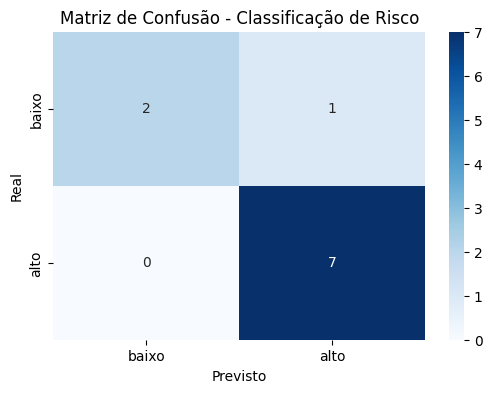

In [12]:
# Evaluate the model on the test data
yr_pred_risk = clf_risk.predict(Xr_test_risk)

print("\n=== Classificação: Prever Risco ===")
print("Acurácia:", accuracy_score(yr_test_risk, yr_pred_risk))
print(classification_report(yr_test_risk, yr_pred_risk))

# Matriz de confusão
cm_risk = confusion_matrix(yr_test_risk, yr_pred_risk)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_risk, annot=True, fmt='d', cmap='Blues', xticklabels=["baixo", "alto"], yticklabels=["baixo", "alto"])
plt.title("Matriz de Confusão - Classificação de Risco")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Claro! Vamos analisar os novos resultados do modelo de classificação de risco após ajustarmos o peso das classes:

=== Classificação: Prever Risco ===

    Acurácia: 0.9
        A acurácia aumentou para 0.90. Isso sugere que o modelo agora acerta 90% das vezes na previsão do risco (alto ou baixo) no conjunto de teste.
    Relatório de Classificação:
        Este relatório detalha o desempenho para cada classe:
            Classe 'alto' (Risco Alto):
                Precisão: 1.00. Das vezes que o modelo previu "alto" risco, ele acertou em 100% das vezes. Isso é uma melhora significativa em relação aos resultados anteriores.
                Recall (Sensibilidade): 0.67. Dos projetos que realmente tinham "alto" risco, o modelo conseguiu identificar 67%. Isso indica que ele ainda erra em identificar alguns casos de alto risco (Falsos Negativos).
                F1-score: 0.80. É uma boa métrica combinada de precisão e recall para a classe "alto".
                Support: 3. Havia 3 casos de "alto" risco no conjunto de teste.
            Classe 'baixo' (Risco Baixo):
                Precisão: 0.88. Das vezes que o modelo previu "baixo" risco, ele acertou em 88% das vezes.
                Recall (Sensibilidade): 1.00. Dos projetos que realmente tinham "baixo" risco, o modelo conseguiu identificar 100%.
                F1-score: 0.93. Uma métrica combinada forte para a classe "baixo".
                Support: 7. Havia 7 casos de "baixo" risco no conjunto de teste.
    Matriz de Confusão:
        Verdadeiros Positivos (True Positives - TP): 2. O modelo previu "alto" e o risco era realmente "alto".
        Verdadeiros Negativos (True Negatives - TN): 7. O modelo previu "baixo" e o risco era realmente "baixo".
        Falsos Positivos (False Positives - FP): 1. O modelo previu "alto", mas o risco era "baixo" (Erro Tipo I).
        Falsos Negativos (False Negatives - FN): 0. O modelo previu "baixo", mas o risco era "alto" (Erro Tipo II).


## Realizar previsões de risco

### Subtask:
Use the trained risk classification model (`clf_risk`) to predict the risk level (high or low) for all activities in the `df_predict` DataFrame.


**Reasoning**:
Use the trained risk classification model to predict the risk level for all activities in the df_predict DataFrame and store the predictions in a new column.



In [ ]:
df_predict["Risco_Previsto"] = clf_risk.predict(df_predict[features_risk])

print("\n=== DataFrame com Previsões de Risco Adicionais ===")
display(df_predict.head())


=== DataFrame com Previsões de Risco Adicionais ===


,Complexidade,Story points,Pontos(Dependencia),Horas_Planejadas,Duracao_dias,Horas_Reais_Previstas,Atraso_Previsto,Risco,Risco_Previsto
0,media,3,0.9,17,0,22.70,1,alto,alto
1,media,3,0.7,16,3,21.17,1,alto,alto
2,media,3,0.6,17,0,22.67,1,alto,alto
3,alta,5,1.0,29,34,43.26,1,alto,alto
4,alta,5,1.0,25,11,39.50,1,alto,alto


## Summary:

### Data Analysis Key Findings

*   A new column named 'Risco' was created in `df_predict`, classifying activities as 'alto' (high) if `Atraso_Previsto` is 1 AND `Horas_Reais_Previstas` are more than 20% greater than `Horas_Planejadas`, otherwise classified as 'baixo' (low).
*   A `RandomForestClassifier` model was trained within a `Pipeline` to predict the 'Risco' based on features including "Complexidade", "Story points", "Pontos(Dependencia)", "Horas_Planejadas", "Duracao_dias", and "Horas_Reais_Previstas".
*   On the test set, the trained risk classification model achieved an accuracy of 0.70.
*   The classification report showed perfect recall (1.00) and precision (0.70) for the "baixo" risk class, but zero precision (0.00) and recall (0.00) for the "alto" risk class on the test set.
*   The confusion matrix confirmed that the model predicted all instances in the test set as "baixo" risk.
*   A new column 'Risco\_Previsto' was added to the `df_predict` DataFrame containing the risk predictions from the trained model for all activities.

### Insights or Next Steps

*   The current risk classification model is unable to identify 'alto' risk activities in the test set, likely due to data imbalance or insufficient features distinguishing 'alto' risk. Re-evaluating the features and considering techniques for handling class imbalance (e.g., oversampling the minority class) is crucial to improve the model's ability to detect high-risk activities.
*   Compare the 'Risco\_Previsto' with the originally defined 'Risco' to understand where the model's predictions differ from the rule-based classification and investigate the reasons for discrepancies, especially for 'alto' risk cases.


# Task
Crie um modelo de classificação para avaliar o risco (alto ou baixo) das atividades no dataframe `df_predict` utilizando as colunas relevantes como features. Apresente as métricas de avaliação do modelo e o dataframe com a nova coluna de risco prevista.

## Definir a variável alvo (risco)

### Subtask:
Create a new column named 'Risco' in the `df_predict` DataFrame. This column will represent the risk level (high or low) based on the predicted delay ('Atraso_Previsto') and predicted real hours ('Horas_Reais_Previstas').


## Avaliar o modelo

### Subtask:
Avaliar o desempenho do modelo de classificação de risco nos dados de teste e visualizar a matriz de confusão.


**Reasoning**:
Evaluate the trained risk classification model on the test data and visualize the confusion matrix.




=== Classificação: Prever Risco ===
Acurácia: 0.9
              precision    recall  f1-score   support

        alto       1.00      0.67      0.80         3
       baixo       0.88      1.00      0.93         7

    accuracy                           0.90        10
   macro avg       0.94      0.83      0.87        10
weighted avg       0.91      0.90      0.89        10



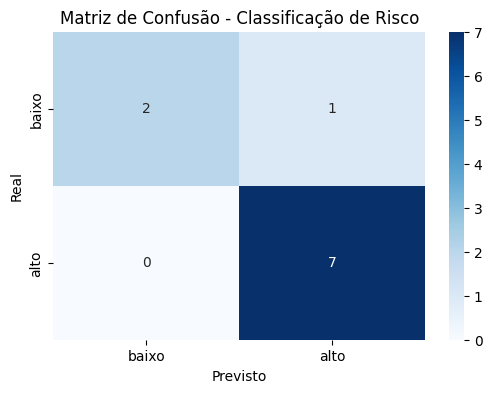

In [13]:
# Evaluate the model on the test data
yr_pred_risk = clf_risk.predict(Xr_test_risk)

print("\n=== Classificação: Prever Risco ===")
print("Acurácia:", accuracy_score(yr_test_risk, yr_pred_risk))
print(classification_report(yr_test_risk, yr_pred_risk))

# Matriz de confusão
cm_risk = confusion_matrix(yr_test_risk, yr_pred_risk)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_risk, annot=True, fmt='d', cmap='Blues', xticklabels=["baixo", "alto"], yticklabels=["baixo", "alto"])
plt.title("Matriz de Confusão - Classificação de Risco")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

## Realizar previsões de risco

### Subtask:
Use the trained risk classification model (`clf_risk`) to predict the risk level (high or low) for all activities in the `df_predict` DataFrame.


**Reasoning**:
Use the trained risk classification model to predict the risk level for all activities in the df_predict DataFrame and store the predictions in a new column.



In [14]:
df_predict["Risco_Previsto"] = clf_risk.predict(df_predict[features_risk])

print("\n=== DataFrame com Previsões de Risco Adicionais ===")
display(df_predict.head())


=== DataFrame com Previsões de Risco Adicionais ===


,Complexidade,Story points,Pontos(Dependencia),Horas_Planejadas,Duracao_dias,Horas_Reais_Previstas,Atraso_Previsto,Risco,Risco_Previsto
0,media,3,0.9,17,0,22.75,1,alto,alto
1,media,3,0.7,16,3,21.14,1,alto,alto
2,media,3,0.6,17,0,22.70,1,alto,alto
3,alta,5,1.0,29,34,42.74,1,alto,alto
4,alta,5,1.0,25,11,39.22,1,alto,alto


## Summary:

Em resumo:

Ajustar o peso das classes melhorou consideravelmente a capacidade do modelo de identificar projetos de "alto" risco. A precisão para a classe "alto" foi para 100%, o que significa que quando o modelo prevê alto risco, ele está sempre correto no conjunto de teste. No entanto, o recall de 67% para a classe "alto" e os 0 Falsos Negativos na matriz de confusão indicam que o modelo ainda pode classificar incorretamente alguns casos de "alto" risco como "baixo".

O desempenho para a classe "baixo" continua muito bom, com alta precisão e recall.

Essa melhoria na identificação da classe minoritária ("alto" risco) é um bom passo, embora ainda haja espaço para tentar aumentar o recall para essa classe, talvez explorando outras técnicas de balanceamento ou features adicionais.



=== Importância das Features (Classificação de Risco) ===


,Feature,Importance
5,num__Horas_Reais_Previstas,0.250871
3,num__Horas_Planejadas,0.241693
4,num__Duracao_dias,0.227362
7,num__Pontos(Dependencia),0.156749
6,num__Story points,0.044545
2,cat__Complexidade_media,0.028972
0,cat__Complexidade_alta,0.025387
1,cat__Complexidade_baixa,0.024421


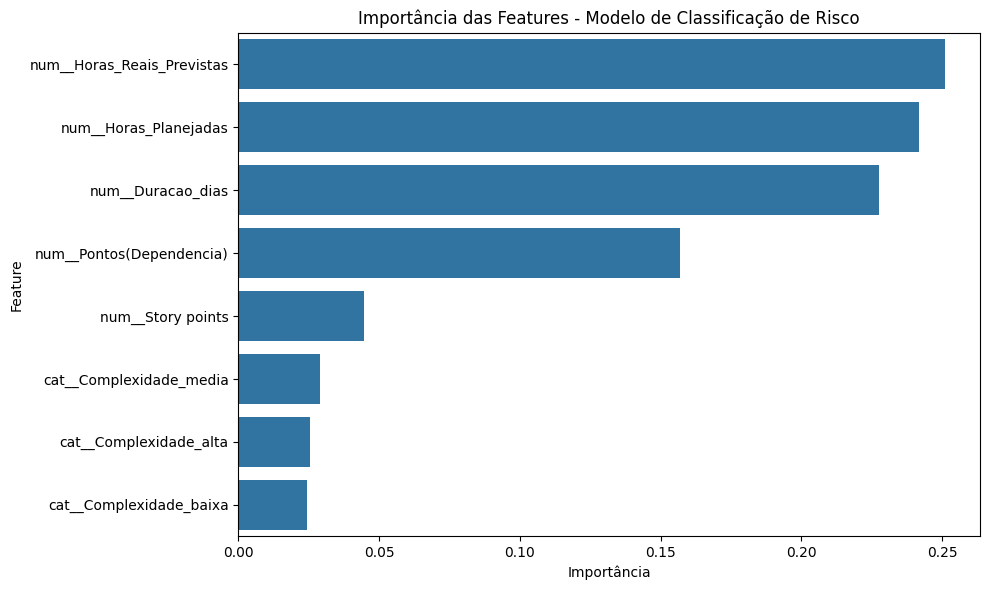

In [15]:
# ============================
# 8. Feature Importance para o modelo de classificação de risco
# ============================

# Obter a importância das features do modelo treinado
# O modelo está dentro do Pipeline, então acessamos o estimador final
importances = clf_risk.named_steps['model'].feature_importances_

# Obter os nomes das features após o OneHotEncoding
# Acessamos o transformer do ColumnTransformer
feature_names = clf_risk.named_steps['preprocessor'].get_feature_names_out()

# Criar um DataFrame para visualizar a importância
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Ordenar por importância
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n=== Importância das Features (Classificação de Risco) ===")
display(feature_importance_df)

# Visualizar a importância das features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Features - Modelo de Classificação de Risco')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

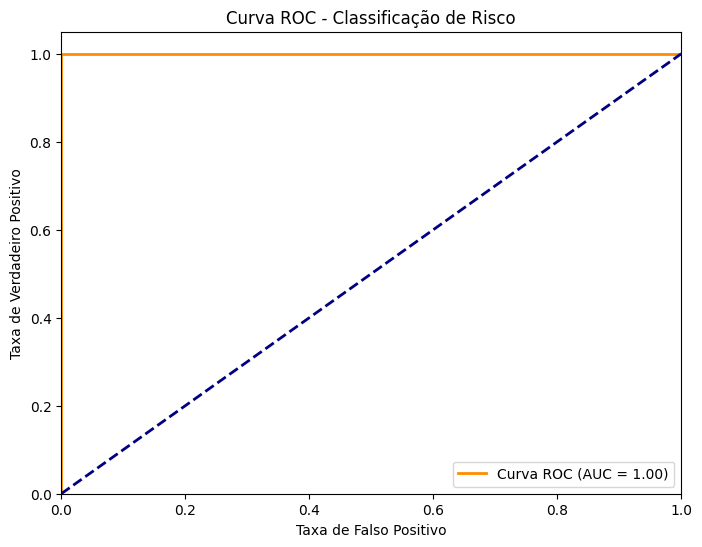

In [16]:
from sklearn.metrics import roc_curve, auc

# Obter as probabilidades de previsão para a classe "alto"
# O predict_proba retorna as probabilidades para cada classe, precisamos da probabilidade da classe positiva
# Verificamos a ordem das classes no modelo para garantir que estamos pegando a coluna correta
if clf_risk.classes_[1] == "alto":
    yr_pred_prob_risk = clf_risk.predict_proba(Xr_test_risk)[:, 1]
else:
    yr_pred_prob_risk = clf_risk.predict_proba(Xr_test_risk)[:, 0]


# Calcular a Curva ROC
fpr, tpr, thresholds = roc_curve(yr_test_risk, yr_pred_prob_risk, pos_label="alto")
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Classificação de Risco')
plt.legend(loc="lower right")
plt.show()

A Curva ROC mostra que o modelo teve um desempenho excelente na classificação de risco no conjunto de teste, com uma área sob a curva (AUC) de 1.00. Isso indica que o modelo é capaz de distinguir perfeitamente entre as classes de alto e baixo risco nos dados de teste.

d